In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tabulate import tabulate
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy
import csv

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'car', 'bird', 'cat'}
fg_used = '123'
fg1, fg2, fg3 = 1,2,3

background_classes = {'plane', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}

# print(type(foreground_classes))

In [0]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    

In [0]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

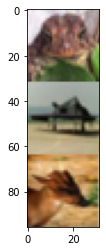

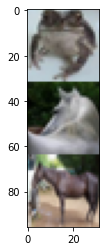

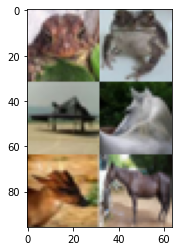

torch.Size([3, 96, 32])


In [8]:
img1 = torch.cat((background_data[0],background_data[1],background_data[2]),1)
imshow(img1)
img2 = torch.cat((background_data[27],background_data[3],background_data[43]),1)
imshow(img2)
img3 = torch.cat((img1,img2),2)
imshow(img3)
print(img2.size())


In [0]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx] - fg1  # minus fg1 because our fore ground classes are fg1,fg2,fg3 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [0]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
list_set_labels = [] 
for i in range(desired_num):
  set_idx = set()
  bg_idx = np.random.randint(0,35000,8)
  set_idx = set(background_label[bg_idx].tolist())
  fg_idx = np.random.randint(0,15000)
  set_idx.add(foreground_label[fg_idx].item())
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)
  list_set_labels.append(set_idx)


2


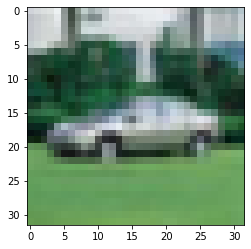

plane


In [11]:
qw=45

print(fore_idx[qw])
imshow(mosaic_list_of_images[qw][fore_idx[qw]])
# print(mosaic_list_of_images[0])
print(classes[mosaic_label[qw]]) 

# imshow(mosaic_list_of_images[13][2])
# print(type(mosaic_list_of_images[1][0]))
# print(mosaic_label)

In [0]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [0]:
# class Module1(nn.Module):
#   def __init__(self):
#     super(Module1, self).__init__()
#     self.conv1 = nn.Conv2d(3, 6, 5)
#     self.pool = nn.MaxPool2d(2, 2)
#     self.conv2 = nn.Conv2d(6, 16, 5)
#     self.fc1 = nn.Linear(16 * 5 * 5, 120)
#     self.fc2 = nn.Linear(120, 84)
#     self.fc3 = nn.Linear(84, 10)
#     self.fc4 = nn.Linear(10,1)

#   def forward(self, z):
#     x = torch.zeros([batch,9],dtype=torch.float64)
#     y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
#     x,y = x.to("cuda"),y.to("cuda")
#     for i in range(9):
#       x[:,i] = self.helper(z[:,i])[:,0]
#     x = F.softmax(x,dim=1)   # alphas
    
#     x1 = x[:,0]
#     torch.mul(x1[:,None,None,None],z[:,0])

#     for i in range(9):            
#       x1 = x[:,i]          
#       y = y + torch.mul(x1[:,None,None,None],z[:,i])
#     return y , x 
  
#   def helper(self,x):
#     x = self.pool(F.relu(self.conv1(x)))
#     x = self.pool(F.relu(self.conv2(x)))
#     # x = x.contiguous()
#     # print("x before", x.shape)
#     x = x.view(-1, 16 * 5 * 5)
#     # print("x after", x.shape)
#     x = F.relu(self.fc1(x))
#     x = F.relu(self.fc2(x))
#     x = F.relu(self.fc3(x))
#     x = self.fc4(x)
#     return x

class Module1(nn.Module):
  def __init__(self):
    super(Module1, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,1)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [0]:
# class Module2(nn.Module):
#   def __init__(self):
#     super(Module2, self).__init__()
    
#     self.conv1 = nn.Conv2d(3, 6, 5)
#     self.pool = nn.MaxPool2d(2, 2)
#     self.conv2 = nn.Conv2d(6, 16, 5)
#     self.fc1 = nn.Linear(16 * 5 * 5, 120)
#     self.fc2 = nn.Linear(120, 84)
#     self.fc3 = nn.Linear(84, 10)
#     self.fc4 = nn.Linear(10,3)

#   def forward(self,y):  #z batch of list of 9 images
#     y1 = self.pool(F.relu(self.conv1(y)))
#     y1 = self.pool(F.relu(self.conv2(y1)))
#     # print(y1.shape)
#     y1 = y1.reshape(-1, 16 * 5 * 5)

#     y1 = F.relu(self.fc1(y1))
#     y1 = F.relu(self.fc2(y1))
#     y1 = F.relu(self.fc3(y1))
#     y1 = self.fc4(y1)
#     return y1

class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    self.module1 = Module1().double()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self,z):  #z batch of list of 9 images
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x = torch.zeros([batch,9],dtype=torch.float64)
    x = x.to("cuda")
    y = y.to("cuda")
    for i in range(9):
        x[:,i] = self.module1.forward(z[:,i])[:,0]

    x = F.softmax(x,dim=1)

    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])
      y = y.contiguous()


    y1 = self.pool(F.relu(self.conv1(y)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    y1 = y1.contiguous()
    y1 = y1.reshape(-1, 16 * 5 * 5)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1 , x, y

In [0]:
# where_net = Module1().double()
# where_net = where_net.to("cuda")

In [0]:
# what_net = Module2().double()
# what_net = what_net.to("cuda")

In [0]:
fore_net = Module2().double()
fore_net = fore_net.to("cuda")

In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# optimizer_where = optim.SGD(where_net.parameters(), lr=0.01, momentum=0.9)
# optimizer_what = optim.SGD(what_net.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.SGD(fore_net.parameters(), lr=0.01, momentum=0.9)
nos_epochs = 600

for epoch in range(nos_epochs):  # loop over the dataset multiple times

  running_loss = 0.0
  cnt=0
  mini_loss = []

  iteration = desired_num // batch
  
  #training data set
  
  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    inputs, labels, fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    # zero the parameter gradients
    
    # optimizer_what.zero_grad()
    # optimizer_where.zero_grad()
    optimizer.zero_grad()
    
    # avg_images , alphas = where_net(inputs)
    # avg_images = avg_images.contiguous()
    # outputs = what_net(avg_images)

    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

    loss = criterion(outputs, labels) 
    loss.backward()
    # optimizer_what.step()
    # optimizer_where.step()
    optimizer.step()
    running_loss += loss.item()
    mini = 40
  
    if cnt % mini == mini - 1:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      mini_loss.append(running_loss / mini)
      running_loss = 0.0
      
    cnt=cnt+1
  if(np.average(mini_loss) <= 0.05):
    break
print('Finished Training')
# torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/drill_deep_cifar/weights/model_epoch"+str(nos_epochs)+".pt")
# torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/drill_deep_cifar/weights/model_epoch"+str(nos_epochs)+".pt")

[1,    40] loss: 1.104
[1,    80] loss: 1.099
[1,   120] loss: 1.099
[2,    40] loss: 1.098
[2,    80] loss: 1.099
[2,   120] loss: 1.099
[3,    40] loss: 1.099
[3,    80] loss: 1.099
[3,   120] loss: 1.098
[4,    40] loss: 1.098
[4,    80] loss: 1.099
[4,   120] loss: 1.099
[5,    40] loss: 1.099
[5,    80] loss: 1.099
[5,   120] loss: 1.099
[6,    40] loss: 1.098
[6,    80] loss: 1.099
[6,   120] loss: 1.099
[7,    40] loss: 1.099
[7,    80] loss: 1.098
[7,   120] loss: 1.099
[8,    40] loss: 1.099
[8,    80] loss: 1.099
[8,   120] loss: 1.099
[9,    40] loss: 1.099
[9,    80] loss: 1.099
[9,   120] loss: 1.099
[10,    40] loss: 1.099
[10,    80] loss: 1.099
[10,   120] loss: 1.099
[11,    40] loss: 1.099
[11,    80] loss: 1.099
[11,   120] loss: 1.098
[12,    40] loss: 1.099
[12,    80] loss: 1.099
[12,   120] loss: 1.099
[13,    40] loss: 1.099
[13,    80] loss: 1.098
[13,   120] loss: 1.099
[14,    40] loss: 1.099
[14,    80] loss: 1.099
[14,   120] loss: 1.098
[15,    40] loss: 1

In [0]:
torch.save(fore_net.state_dict(),"/content/drive/My Drive/Research/drill_deep_cifar/weights/fore_net_epoch"+str(epoch)+"_fg_used"+str(fg_used)+".pt")
# torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/drill_deep_cifar/weights/model_epoch"+str(nos_epochs)+".pt")

In [0]:
# fore_net.load_state_dict(torch.load("/content/drive/My Drive/Research/drill_deep_cifar/weights/fore_net_epoch150_fg_used012.pt"))

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
test_set_labels = []
for i in range(10000):
  set_idx = set()
  bg_idx = np.random.randint(0,35000,8)
  set_idx = set(background_label[bg_idx].tolist())
  fg_idx = np.random.randint(0,15000)
  set_idx.add(foreground_label[fg_idx].item())
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)
  test_set_labels.append(set_idx)


In [0]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [23]:
torch.argmax(alphas[5]), alphas[5]

(tensor(0, device='cuda:0'),
 tensor([8.5918e-01, 4.4497e-05, 1.1087e-02, 5.0935e-02, 7.2816e-03, 7.9395e-03,
         1.7193e-02, 6.3628e-03, 3.9975e-02], device='cuda:0',
        dtype=torch.float64, grad_fn=<SelectBackward>))

In [0]:
test_set = DataLoader( test_data,batch_size= batch ,shuffle=False)
train_set = DataLoader( msd,batch_size= batch ,shuffle=False)


###Lets see the % of FTPT, FFPT, FTPF, FFPF for FG classes separetly

In [0]:
fg = [1,2,3]
bg = [0,4,5,6,7,8,9]

In [29]:
from tabulate import tabulate
table = []
entry_no = 1


# cnt=0
for a in fg :
  count = 0
  correct = 0
  total = 0
  focus_true_pred_true = 0
  focus_false_pred_true = 0
  focus_true_pred_false = 0
  focus_false_pred_false = 0
  argmax_more_than_half = 0
  argmax_less_than_half = 0
  with torch.no_grad():
    for data in train_set:
      inputs, labels , fore_idx = data
      inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
      outputs, alphas, avg_images = fore_net(inputs)

      _, predicted = torch.max(outputs.data, 1)

      for m in range(labels.size(0)):
        # count
        if(count == 30000):
          break
        s = list_set_labels[count]
        # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
        if (a in s ):
          # print(str(a)+str(b1)+str(b2)+str(b3))
          total += 1
          focus = torch.argmax(alphas[m])
          if alphas[m][focus] >= 0.5 :
            argmax_more_than_half += 1
          else:
            argmax_less_than_half += 1

          if(focus == fore_idx[m] and predicted[m] == labels[m]):
              focus_true_pred_true += 1
          elif(focus != fore_idx[m] and predicted[m] == labels[m]):
            focus_false_pred_true += 1
          elif(focus == fore_idx[m] and predicted[m] != labels[m]):
            focus_true_pred_false += 1
          elif(focus != fore_idx[m] and predicted[m] != labels[m]):
            focus_false_pred_false += 1
        
        count += 1
      
    correct += (predicted == labels).sum().item()  
    entry = [entry_no,'fg = '+str(a) , 'bg = all_except_fg', total]
    if total == 0:
      entry.append(0)
      entry.append(0)
      entry.append(0)
      entry.append(0)
    else:
      entry.append((100 * focus_true_pred_true / total))
      entry.append( (100 * focus_false_pred_true / total))
      entry.append( ( 100 * focus_true_pred_false / total))
      entry.append( ( 100 * focus_false_pred_false / total))
    entry.append( argmax_more_than_half)
    table.append(entry)
    entry_no += 1

print(tabulate(table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


  S.No.  fg_class    bg_class              data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  ----------  ------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = 1      bg = all_except_fg          10144    95.4259    4.21924  0.0887224   0.266167             9904
      2  fg = 2      bg = all_except_fg           9886    60.9144   36.1926   0.79911     2.09387              6145
      3  fg = 3      bg = all_except_fg           9970    48.5155   50.3109   0.240722    0.932798             5207


In [30]:
# for testing_set
table = []
entry_no = 1

# cnt=0
for a in fg :
  count = 0
  correct = 0
  total = 0
  focus_true_pred_true = 0
  focus_false_pred_true = 0
  focus_true_pred_false = 0
  focus_false_pred_false = 0
  argmax_more_than_half = 0
  argmax_less_than_half = 0
  with torch.no_grad():
    for data in test_set:
      inputs, labels , fore_idx = data
      inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
      outputs, alphas, avg_images = fore_net(inputs)

      _, predicted = torch.max(outputs.data, 1)

      for m in range(labels.size(0)):
        # count
        if(count == 10000):
          break
        s = list_set_labels[count]
        # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
        if (a in s ):
          # print(str(a)+str(b1)+str(b2)+str(b3))
          total += 1
          focus = torch.argmax(alphas[m])
          if alphas[m][focus] >= 0.5 :
            argmax_more_than_half += 1
          else:
            argmax_less_than_half += 1

          if(focus == fore_idx[m] and predicted[m] == labels[m]):
              focus_true_pred_true += 1
          elif(focus != fore_idx[m] and predicted[m] == labels[m]):
            focus_false_pred_true += 1
          elif(focus == fore_idx[m] and predicted[m] != labels[m]):
            focus_true_pred_false += 1
          elif(focus != fore_idx[m] and predicted[m] != labels[m]):
            focus_false_pred_false += 1
        
        count += 1
      
    correct += (predicted == labels).sum().item()  
    entry = [entry_no,'fg = '+str(a) , 'bg = all_except_fg', total]
    if total == 0:
      entry.append(0)
      entry.append(0)
      entry.append(0)
      entry.append(0)
    else:
      entry.append((100 * focus_true_pred_true / total))
      entry.append( (100 * focus_false_pred_true / total))
      entry.append( ( 100 * focus_true_pred_false / total))
      entry.append( ( 100 * focus_false_pred_false / total))
    entry.append( argmax_more_than_half)
    table.append(entry)
    entry_no += 1

print(tabulate(table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


  S.No.  fg_class    bg_class              data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  ----------  ------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = 1      bg = all_except_fg           3334    56.7187    19.796     5.06899    18.4163             2107
      2  fg = 2      bg = all_except_fg           3330    57.0571    18.9489    4.86486    19.1291             2156
      3  fg = 3      bg = all_except_fg           3336    57.524     18.3453    5.45564    18.6751             2135


###Lets see the % of FTPT, FFPT, FTPF, FFPF for FG classes with 3 bg classes separetly


In [31]:
fg, str(fg)

([1, 2, 3], '[1, 2, 3]')

In [32]:
from tabulate import tabulate
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_set:
    inputs, labels , fore_idx = data
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      count += 1
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)
print(count)

print("="*100)
table = []
entry = [1,'fg = '+ str(fg),'bg = '+str(bg),30000]
entry.append((100 * focus_true_pred_true / total))
entry.append( (100 * focus_false_pred_true / total))
entry.append( ( 100 * focus_true_pred_false / total))
entry.append( ( 100 * focus_false_pred_false / total))
entry.append( argmax_more_than_half)
table.append(entry)

print(tabulate(table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT', 'FFPT', 'FTPF', 'FFPF', 'avg_img > 0.5'] ) )


Accuracy of the network on the 30000 train images: 98 %
total correct 29561
total train set images 30000
focus_true_pred_true 20539 =============> FTPT : 68 %
focus_false_pred_true 9022 =============> FFPT : 30 %
focus_true_pred_false 112 =============> FTPF : 0 %
focus_false_pred_false 327 =============> FFPF : 1 %
argmax_more_than_half 21256
argmax_less_than_half 8744
30000
  S.No.  fg_class        bg_class                      data_points     FTPT     FFPT      FTPF    FFPF    avg_img > 0.5
-------  --------------  --------------------------  -------------  -------  -------  --------  ------  ---------------
      1  fg = [1, 2, 3]  bg = [0, 4, 5, 6, 7, 8, 9]          30000  68.4633  30.0733  0.373333    1.09            21256


In [33]:
entry_no = 2
# train_set = DataLoader( msd,batch_size= batch ,shuffle=False)
# fg = [1,2,3]
# bg = [0,4,5,6,7,8,9]

# cnt=0
for a in fg :
  for i in range(5):
    b1 = bg[i]
    for j in range(i+1 , 6): 
      b2 = bg[j]
      for k in range(j+1 , 7):
        b3 = bg[k]
        # cnt+=1
        # print( cnt , a,b1,b2,b3)
        count = 0
        correct = 0
        total = 0
        focus_true_pred_true = 0
        focus_false_pred_true = 0
        focus_true_pred_false = 0
        focus_false_pred_false = 0
        argmax_more_than_half = 0
        argmax_less_than_half = 0
        with torch.no_grad():
          for data in train_set:
            inputs, labels , fore_idx = data
            inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
            outputs, alphas, avg_images = fore_net(inputs)

            _, predicted = torch.max(outputs.data, 1)

            for m in range(labels.size(0)):
              # count
              if(count == 30000):
                break
              s = list_set_labels[count]
              # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
              if (a in s and b1 in s and b2 in s and b3 in s):
                # print(str(a)+str(b1)+str(b2)+str(b3))
                total += 1
                focus = torch.argmax(alphas[m])
                if alphas[m][focus] >= 0.5 :
                  argmax_more_than_half += 1
                else:
                  argmax_less_than_half += 1

                if(focus == fore_idx[m] and predicted[m] == labels[m]):
                    focus_true_pred_true += 1
                elif(focus != fore_idx[m] and predicted[m] == labels[m]):
                  focus_false_pred_true += 1
                elif(focus == fore_idx[m] and predicted[m] != labels[m]):
                  focus_true_pred_false += 1
                elif(focus != fore_idx[m] and predicted[m] != labels[m]):
                  focus_false_pred_false += 1
              
              count += 1
            
          correct += (predicted == labels).sum().item()  
          entry = [entry_no,'fg = '+str(a) , 'bg = '+ str(b1)+',' + str(b2)+',' + str(b3), total]
          if total == 0:
            entry.append(0)
            entry.append(0)
            entry.append(0)
            entry.append(0)
          else:
            entry.append((100 * focus_true_pred_true / total))
            entry.append( (100 * focus_false_pred_true / total))
            entry.append( ( 100 * focus_true_pred_false / total))
            entry.append( ( 100 * focus_false_pred_false / total))
          entry.append( argmax_more_than_half)
          table.append(entry)
          entry_no += 1

print(tabulate(table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [1, 2, 3]  bg = [0, 4, 5, 6, 7, 8, 9]          30000    68.4633   30.0733   0.373333   1.09                 21256
      2  fg = 1          bg = 0,4,5                           3220    95.4348    4.40994  0.0621118  0.0931677             3151
      3  fg = 1          bg = 0,4,6                           3134    95.4052    4.21187  0.0957243  0.287173              3062
      4  fg = 1          bg = 0,4,7                           3166    95.7675    3.9482   0.0315856  0.252685              3104
      5  fg = 1          bg = 0,4,8                           3207    95.9152    3.89772  0.0623636  0.124727              3140
      6  fg = 1          bg = 0,4,9                           3233    95.3603    4.36127  0.061862   0.2

In [0]:
col = ['configuration','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5']
# df_train = pd.DataFrame()
import csv
with open("/content/drive/My Drive/Research/drill_deep_cifar/train"+str(fg_used)+".csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(table)
  thewriter.writerow(['S.No.','configuration','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(table[i])

In [35]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_set:
    inputs, labels , fore_idx = data
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

print("="*100)
table = []
entry = [1,'fg = '+ str(fg),'bg = '+str(bg),10000]
entry.append((100 * focus_true_pred_true / total))
entry.append( (100 * focus_false_pred_true / total))
entry.append( ( 100 * focus_true_pred_false / total))
entry.append( ( 100 * focus_false_pred_false / total))
entry.append( argmax_more_than_half)
table.append(entry)

print(tabulate(table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT', 'FFPT', 'FTPF', 'FFPF', 'avg_img > 0.5'] ) )


Accuracy of the network on the 10000 train images: 76 %
total correct 7613
total train set images 10000
focus_true_pred_true 5710 =============> FTPT : 57 %
focus_false_pred_true 1903 =============> FFPT : 19 %
focus_true_pred_false 513 =============> FTPF : 5 %
focus_false_pred_false 1874 =============> FFPF : 18 %
argmax_more_than_half 6398
argmax_less_than_half 3602
  S.No.  fg_class        bg_class                      data_points    FTPT    FFPT    FTPF    FFPF    avg_img > 0.5
-------  --------------  --------------------------  -------------  ------  ------  ------  ------  ---------------
      1  fg = [1, 2, 3]  bg = [0, 4, 5, 6, 7, 8, 9]          10000    57.1   19.03    5.13   18.74             6398


In [36]:
entry_no = 2
#usinfg test_loader
# fg = [0,1,2]
# bg = [3,4,5,6,7,8,9]

# cnt=0
for a in fg :
  for i in range(5):
    b1 = bg[i]
    for j in range(i+1 , 6): 
      b2 = bg[j]
      for k in range(j+1 , 7):
        b3 = bg[k]
        # cnt+=1
        # print( cnt , a,b1,b2,b3)
        count = 0
        correct = 0
        total = 0
        focus_true_pred_true = 0
        focus_false_pred_true = 0
        focus_true_pred_false = 0
        focus_false_pred_false = 0
        argmax_more_than_half = 0
        argmax_less_than_half = 0
        with torch.no_grad():
          for data in test_set:
            inputs, labels , fore_idx = data
            inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
            outputs, alphas, avg_images = fore_net(inputs)

            _, predicted = torch.max(outputs.data, 1)

            for m in range(labels.size(0)):
              # count
              if(count == 10000):
                break
              s = test_set_labels[count]
              # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
              if (a in s and b1 in s and b2 in s and b3 in s):
                # print(str(a)+str(b1)+str(b2)+str(b3))
                total += 1
                focus = torch.argmax(alphas[m])
                if alphas[m][focus] >= 0.5 :
                  argmax_more_than_half += 1
                else:
                  argmax_less_than_half += 1

                if(focus == fore_idx[m] and predicted[m] == labels[m]):
                    focus_true_pred_true += 1
                elif(focus != fore_idx[m] and predicted[m] == labels[m]):
                  focus_false_pred_true += 1
                elif(focus == fore_idx[m] and predicted[m] != labels[m]):
                  focus_true_pred_false += 1
                elif(focus != fore_idx[m] and predicted[m] != labels[m]):
                  focus_false_pred_false += 1
              
              count += 1
            
          correct += (predicted == labels).sum().item()  
          entry = [entry_no,'fg = '+str(a) , 'bg = '+ str(b1)+',' + str(b2)+',' + str(b3), total]
          if total == 0:
            entry.append(0)
            entry.append(0)
            entry.append(0)
            entry.append(0)
          else:
            entry.append((100 * focus_true_pred_true / total))
            entry.append( (100 * focus_false_pred_true / total))
            entry.append( ( 100 * focus_true_pred_false / total))
            entry.append( ( 100 * focus_false_pred_false / total))
          entry.append( argmax_more_than_half)
          table.append(entry)
          entry_no += 1

print(tabulate(table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [1, 2, 3]  bg = [0, 4, 5, 6, 7, 8, 9]          10000    57.1     19.03        5.13      18.74                6398
      2  fg = 1          bg = 0,4,5                           1087    91.4443   0.459982    2.02392    6.07176             1010
      3  fg = 1          bg = 0,4,6                           1116    90.681    0.448029    2.59857    6.2724              1033
      4  fg = 1          bg = 0,4,7                           1111    90.189    0.540054    2.25023    7.0207              1034
      5  fg = 1          bg = 0,4,8                           1104    91.5761   0.452899    2.17391    5.7971              1030
      6  fg = 1          bg = 0,4,9                           1079    92.1223   0.370714    1.76089    5

In [0]:
col = ['fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5']

In [0]:
import csv
with open("/content/drive/My Drive/Research/drill_deep_cifar/test"+str(fg_used)+".csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(table)
  thewriter.writerow(['S.No.','fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(table[i])

In [39]:
test = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/test"+str(fg_used)+".csv")
test.head()

,S.No.,fg_class,bg_class,data_points,FTPT %,FFPT %,FTPF %,FFPF %,avg_img > 0.5
0,1,"fg = [1, 2, 3]","bg = [0, 4, 5, 6, 7, 8, 9]",10000,57.100000,19.030000,5.130000,18.740000,6398
1,2,fg = 1,"bg = 0,4,5",1087,91.444342,0.459982,2.023919,6.071757,1010
2,3,fg = 1,"bg = 0,4,6",1116,90.681004,0.448029,2.598566,6.272401,1033
3,4,fg = 1,"bg = 0,4,7",1111,90.189019,0.540054,2.250225,7.020702,1034
4,5,fg = 1,"bg = 0,4,8",1104,91.576087,0.452899,2.173913,5.797101,1030


In [0]:
test = np.array(test)

In [41]:
len(test)

106

In [42]:
ftpt_full = test[0][4]
ffpt_full = test[0, 5]
ftpf_full = test[0, 6]
ffpf_full = test[0][7]
ftpt_full, ffpt_full, ftpf_full, ffpf_full

(57.1, 19.03, 5.13, 18.74)

In [43]:
id0 = test[1:35, 2]
ftpt0 = test[1:35, 4]
ffpt0 = test[1:35, 5]
ftpf0 = test[1:35, 6]
ffpf0 = test[1:35, 7]
ftpt0 , id0

(array([91.44434222631097, 90.68100358422942, 90.18901890189021,
        91.57608695652172, 92.12233549582949, 91.18457300275482,
        90.15356820234871, 90.7321594068582, 92.21272554605888,
        90.00892060660125, 90.50632911392404, 91.8572735590119,
        89.88970588235294, 90.81632653061224, 91.43932267168393,
        90.26217228464421, 89.82584784601282, 90.00933706816059,
        91.53187440532824, 89.69917958067457, 90.23090586145649,
        91.78208679593722, 89.95433789954338, 90.96895578551269,
        92.29340761374188, 89.6302975653742, 89.71792538671521,
        91.34438305709023, 89.25992779783394, 90.34676663542645,
        90.57492931196985, 89.58333333333331, 90.84112149532709,
        90.7608695652174], dtype=object),
 array(['bg = 0,4,5', 'bg = 0,4,6', 'bg = 0,4,7', 'bg = 0,4,8',
        'bg = 0,4,9', 'bg = 0,5,6', 'bg = 0,5,7', 'bg = 0,5,8',
        'bg = 0,5,9', 'bg = 0,6,7', 'bg = 0,6,8', 'bg = 0,6,9',
        'bg = 0,7,8', 'bg = 0,7,9', 'bg = 0,8,9', 'bg 

In [0]:
id1 = test[36:70, 2]
ftpt1 = test[36:70, 4]
ffpt1 = test[36:70, 5]
ftpf1 = test[36:70, 6]
ffpf1 = test[36:70, 7]

id2 = test[71:105, 2]
ftpt2 = test[71:105, 4]
ffpt2 = test[71:105, 5]
ftpf2 = test[71:105, 6]
ffpf2 = test[71:105, 7]

In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/plots/fg_'+str(fg_used)+'/'

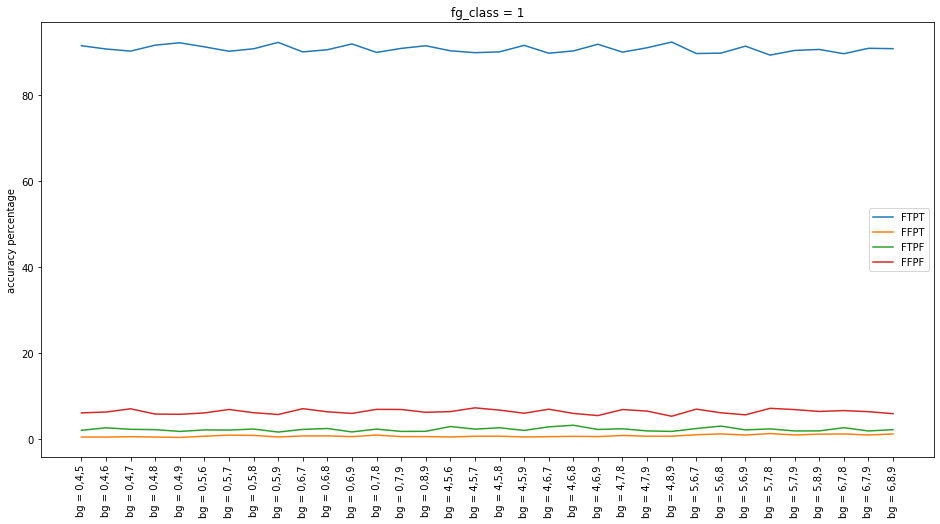

In [46]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1))
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+".pdf", bbox_inches='tight')

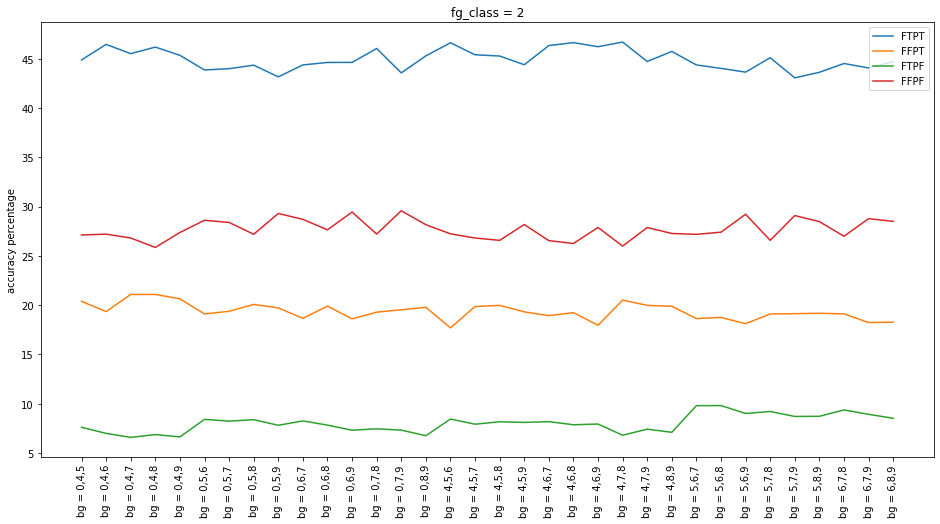

In [47]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2))
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+".pdf", bbox_inches='tight')

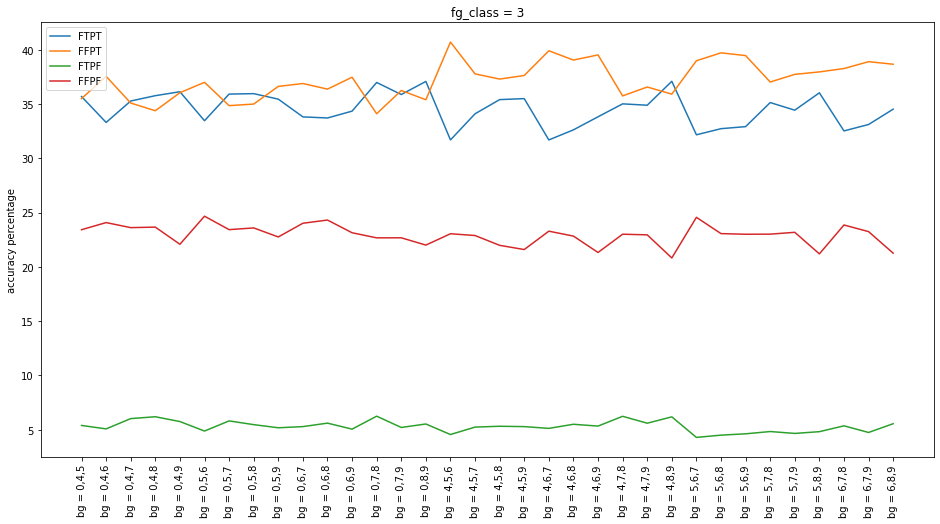

In [48]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3))
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+".pdf", bbox_inches='tight')

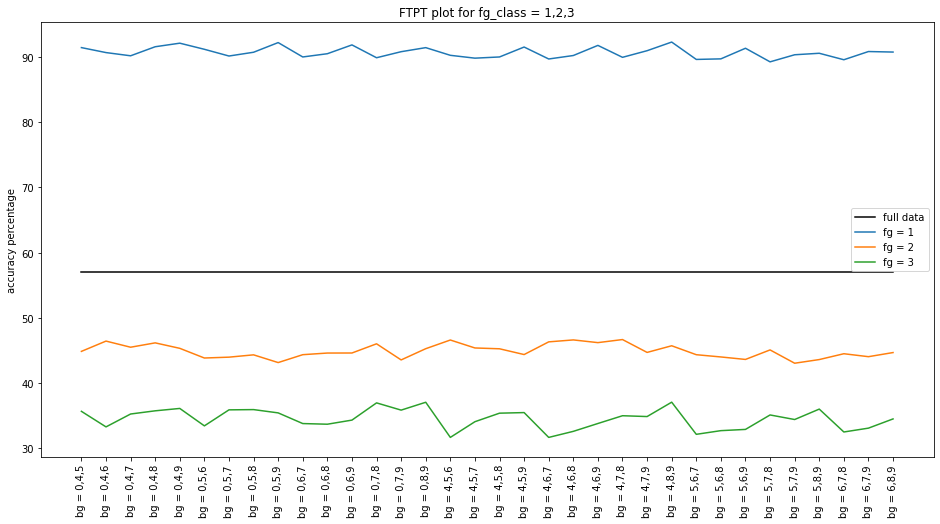

In [49]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3))
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

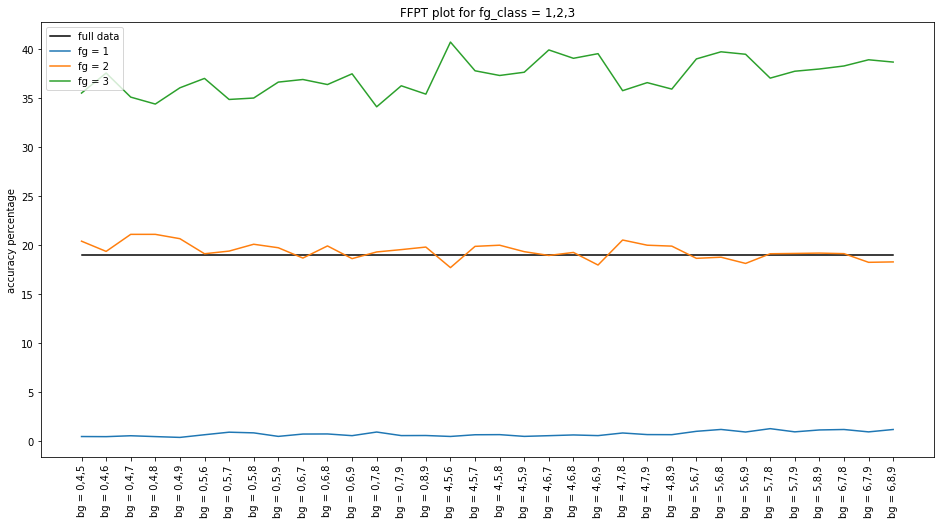

In [50]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3))
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

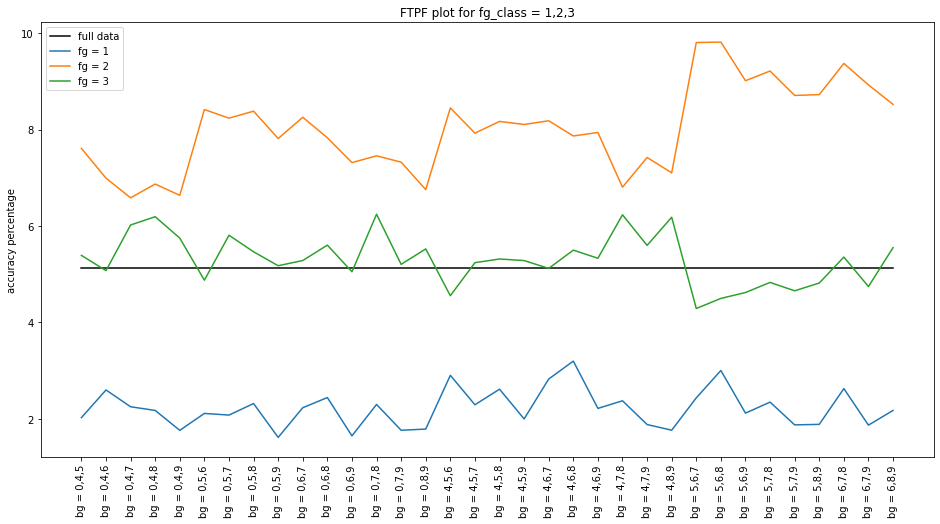

In [51]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3))
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

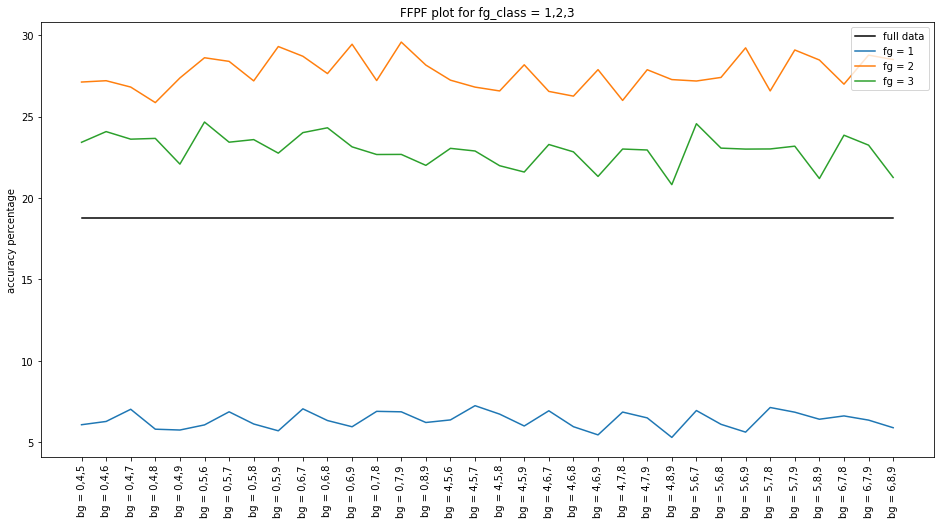

In [52]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3))
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')